# Chapter 15: Mutli-objective Least Squares 

## 15.1 Mutli-objective Least Squares Problem 

In [74]:
# function to solve the multi-objective least squares problem 
# given coefficient matrices (As)
# right-hand side vectors (bs)
# weights (lambdas)
function mult_obj_ls_solve(As,bs,lambdas)
    k = length(lambdas);
    Atilde = vcat([sqrt(lambdas[i]) * As[i] for i=1:k]...)
    btilde = vcat([sqrt(lambdas[i]) * bs[i] for i=1:k]...)
    return Atilde\btilde
end;

**Simple example.** Bi-criterion example to minimize the weighted sum objective

\begin{align}
J_1 + \lambda J_2 = ||A_1 x - b_1||^2 + \lambda ||A_2 x - b_2||^2
\end{align}

for randomly generated $10 \times 5$ matrices $A_1, A_2$ and $10$-vectors $b_1, b_2$. 

We generate and plot 200 values of $\theta \in \[10^{-4}, 10^4\], equally spaced on a logarithmic scale using the code `lambdas = 10 .^ linspace(-4,4,200)`

In [26]:
using VMLS

As = [randn(10,5), randn(10,5)]
bs = [randn(10), randn(10)]
N = 200;

lambdas = 10 .^ linspace(-4,4,N);

In [27]:
# store objective function values and parameters
theta = zeros(5, N); 
J1 = zeros(N);
J2 = zeros(N);

for k=1:N
    thetak = mult_obj_ls_solve(As, bs, [1, lambdas[k]])
    theta[:, k] = thetak
    J1[k] = norm(As[1] * thetak - bs[1])^2
    J2[k] = norm(As[2] * thetak - bs[2])^2
end;

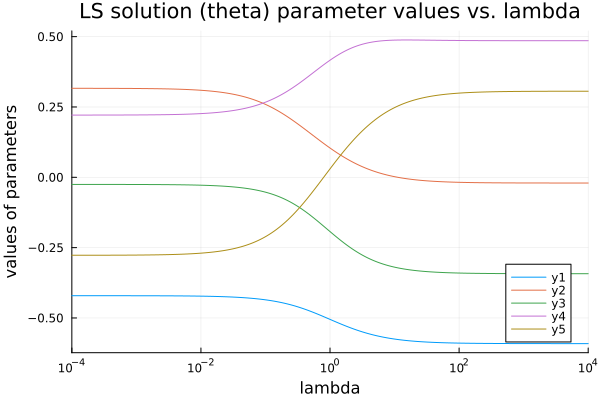

In [28]:
using Plots 

# plot the solution vs. lambda 
plot(xlims = (1e-4,1e4),
    title="LS solution (theta) parameter values vs. lambda");
plot!(lambdas, theta', xscale=:log10, xlabel="lambda", ylabel="values of parameters")

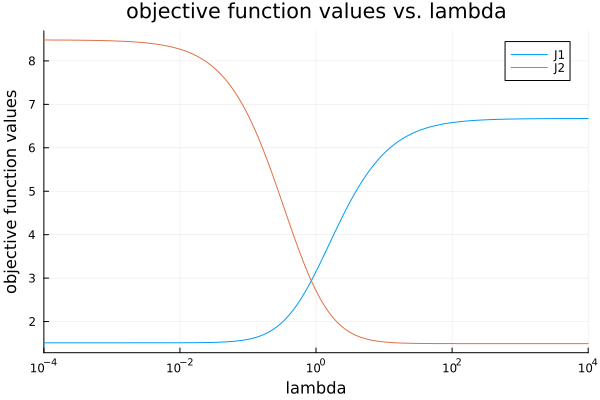

In [29]:
# plot two objective functions vs. lambda 
plot(xlims = (1e-4,1e4),
title="objective function values vs. lambda");
plot!(lambdas, J1, xscale=:log10, xlabel="lambda", ylabel="objective function values", label="J1")
plot!(lambdas, J2, xscale=:log10, label="J2")

In [65]:
lambdas[argmin(abs.(J1-J2))]

0.8703591361485162

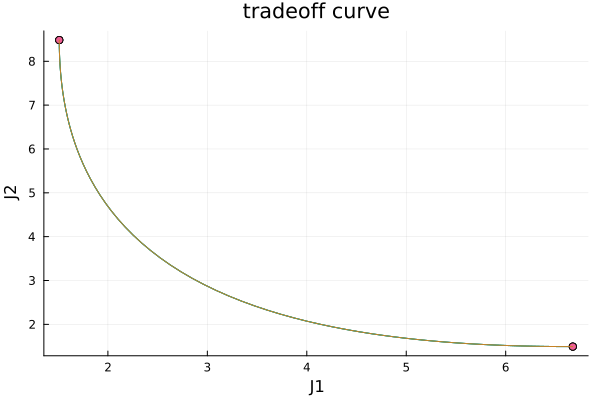

In [35]:
# plot trade-off curve 

# plot the points of the single objective solutions 
x1 = As[1] \ bs[1];
x2 = As[2] \ bs[2];

soJ1 = [norm(As[1]*x1 - bs[1])^2, norm(As[1]*x2 - bs[1])^2]
soJ2 = [norm(As[2]*x1 - bs[2])^2, norm(As[2]*x2 - bs[2])^2]

scatter!(soJ1, soJ2);
plot!(J1, J2, xlabel="J1", ylabel="J2", legend=false, title="tradeoff curve")

## 15.2 Control

(No code)

## 15.3 Estimation and inversion 

**Estimating a periodic time series.** 

Suppose we have a $N$-vector $y$ is a measured time series that we believe is a noisy version of a periodic time series that repeats itself every $P$ periods. 

*Example:* (hourly ozone levels for for a period of 14 days)
Measurements start at 12AM on July 1st, and end at 11PM on July 14.
*Note*: A large number of missing measurements at 4AM.

The periodic time series will be represented by a $P$-vector $x$ which gives its values over one period. It correspoinds to the full time series 

\begin{align}
\hat y = (x,x,\dots,x)
\end{align}

where $x$ is repeated. (We assume that $N$ is a multiple of $P$, ohterwise we slice at the end). We can express $\hat y$ as $\hat y = Ax$ where A is the $N \times P$ selector matrix 

\begin{align}
A = \begin{bmatrix} I \\ \vdots \\ I \end{bmatrix}.
\end{align}

Our objective function / total square estimation error to minimize is $||Ax - y||^2$. 

We can add *regularization* for $x$ to be smooth, based on the assumption that the values of $x$ are similar to neighboring periods

\begin{align}
x_1 \approx x_2, \dots, x_{P-1} \approx x_P, x_P \approx x_1
\end{align}

(Note 'wrap-around' pair $x_P$ and $x_1$).

We measure non-smoothness as $||D^{circ} x||^2$, where $D^{circ}$ is the $P \times P$ *circular difference matrix*

\begin{align}
D^{circ} =  \begin{bmatrix} 
                -1 & 1 & 0 & \dots & 0 & 0 & 0 \\
                0 & -1 & 1 & \dots & 0 & 0 & 0 \\ 
                \vdots & \vdots & \vdots & & \vdots & \vdots & \vdots \\ 
                0 & 0 & 0 & \dots & -1 & 1 & 0 \\ 
                0 & 0 & 0 & \dots & 0 & -1 & 1 \\ 
                1 & 0 & 0 & \dots & 0 & 0 & -1 \\ 
            \end{bmatrix}.
\end{align}

We estimate the periodic time series by minimizing 
\begin{align}
||Ax - y||^2 + \lambda ||D^{circ} x||^2.
\end{align}

For $\lambda = 0$ we get the simple averaging; as $\lambda$ gets bigger, the signal becomes smoother, ultimately converging to a constant. 

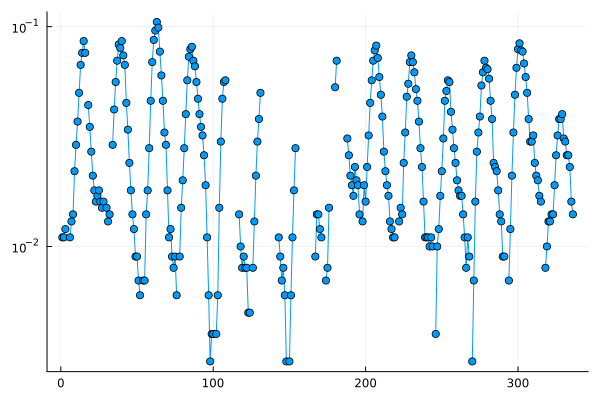

In [40]:
ozone = ozone_data(); 

k = 14; # 14 days
P = 24; # hourly rate
N = k * P; 

plot(1:N, ozone, yscale=:log10, marker=:circle, legend=false)


In [128]:
# periodic multi-objective solve, for lambda values 1 and 10
# we discard missing measurements 

A = vcat([eye(P) for i=1:k]...) 
# periodic difference matrix (D_circ)
D = -eye(P) + [zeros(P-1, 1) eye(P-1); 1 zeros(1, P-1)]

# discard missing measurements 
idx = [k for k=1:N if !isnan(ozone[k])]
b = ozone[idx]

As = [A[idx,:], D] # stack A and D 
bs = [log.(b), zeros(P)];

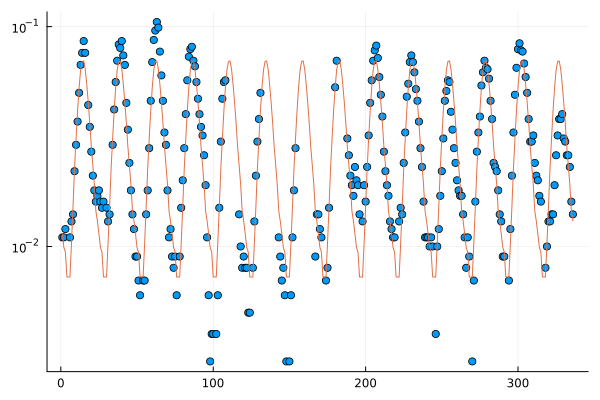

In [57]:
# multi objective solve 
# lambda = 1
theta1 = mult_obj_ls_solve(As, bs, [1,1])
scatter(1:N, ozone, yscale=:log10, legend=false)
plot!(1:N, vcat([exp.(theta1) for i=1:k]...)) 

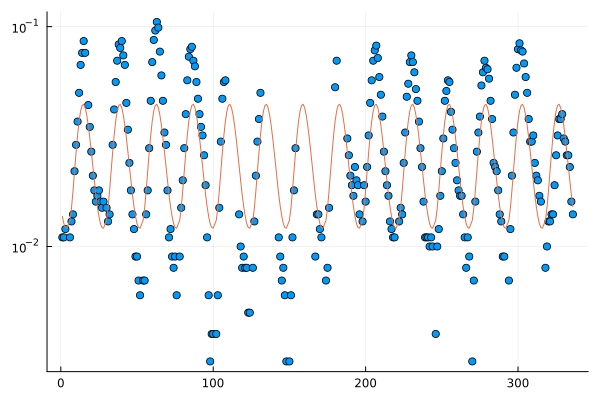

In [58]:
# multi objective solve 
# lambda = 100
theta100 = mult_obj_ls_solve(As, bs, [1,100])
scatter(1:N, ozone, yscale=:log10, legend=false)
plot!(1:N, vcat([exp.(theta100) for i=1:k]...)) 

## 15.4 Regularized data fitting 

We fit a model 

\begin{align}
\hat f(x) = \sum_{k=1}^5 \theta_k f_k(x)
\end{align}

with basis functions $f_1(x) =1$ and $f_{k+1}(x) = sin(\omega_k x + \phi_k)$ for $k = 1,\dots,4$ to $N = 20$ data points. 

We fit the model by solving a sequence of regularized least squares problems with objective 

\begin{align}
\sum_{i=1}^N (y^{(i)} \sum_{k=1}^5 \theta_k f_k(x))^2 + \lambda \sum_{k=2}^5 \theta^2_k
\end{align}

In [85]:
# import the x,y train and test set 
using VMLS
D = regularized_fit_data();
xtrain = D["xtrain"]; ytrain = D["ytrain"];
xtest = D["xtest"]; ytest = D["ytest"];

In [86]:
trainN = length(ytrain);
testN = length(ytest);

omegas = [13.69; 3.55; 23.25; 6.03];
phis = [0.21; 0.02; -1.87; 1.72];
p = length(omegas) + 1; # + 1 for constant f1 

Atrain = hcat(ones(trainN), sin.(xtrain*omegas' + ones(trainN)*phis'))
Atest = hcat(ones(testN), sin.(xtest*omegas' + ones(testN)*phis'));

In [87]:
nlambdas = 100;
# from 10^-6 to 10^6
lambdas = 10 .^ linspace(-6,6, nlambdas)
train_err = zeros(nlambdas);
test_err = zeros(nlambdas);
thetas = zeros(p, nlambdas)

A2 = [zeros(p-1) eye(p-1)] # -1 because only minimizing theta 2-5 (not theta1)
y2 = zeros(p-1) # minimizing theta itself, so y should be 0

for k=1:nlambdas
    theta = mult_obj_ls_solve([Atrain, A2], [ytrain, y2], [1, lambdas[k]])
    thetas[:, k] = theta;
    train_err[k] = rms(ytrain - Atrain*theta)
    test_err[k] = rms(ytest - Atest*theta)
end;

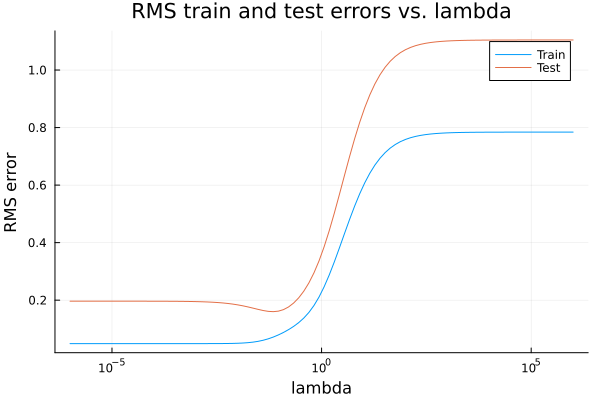

In [90]:
using Plots 
# plot errors for train and test 
plot(lambdas, train_err, xscale=:log10, label="Train")
plot!(lambdas, test_err, label="Test")
plot!(  title="RMS train and test errors vs. lambda",
        xlabel="lambda",
        ylabel="RMS error")

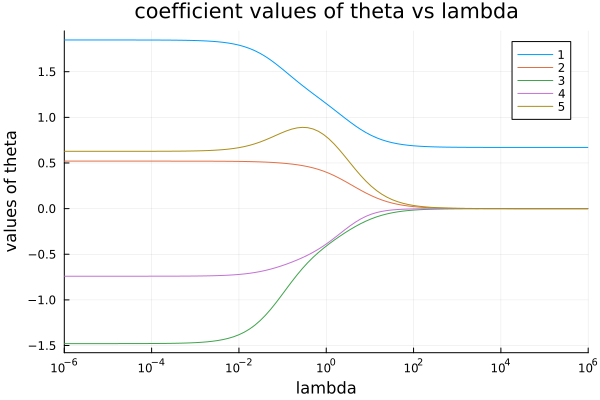

In [143]:
# plot coefficients 
plot(lambdas, thetas', labels=["1" "2" "3" "4" "5"], xscale=:log10,
     xlabel="lambda", ylabel="values of theta",
     title="coefficient values of theta vs lambda",
     xlim=(1e-6,1e6))

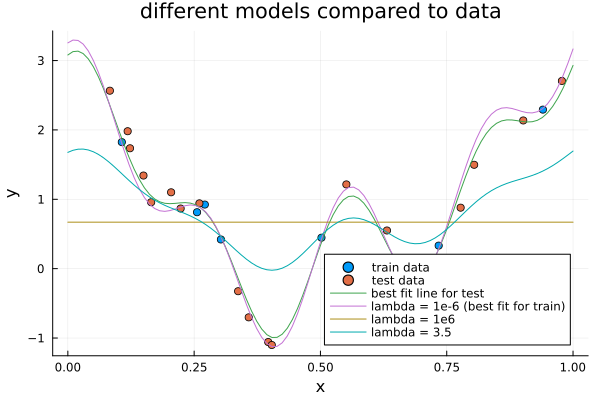

In [126]:
# plot train and test data 
bestk = argmin(test_err)
scatter(xtrain, ytrain, label="train data")
scatter!(xtest, ytest, label="test data")

# plot model 
modelN = 100
modelx = linspace(0,1,modelN)
Amodel = hcat(ones(modelN), sin.(modelx*omegas' + ones(modelN)*phis'));
modelybest = Amodel*thetas[:, bestk]
plot!(modelx, modely, label="best fit line for test")

# plot some other lambdas
modely1 = Amodel*thetas[:, 1]
plot!(modelx, modely1, label="lambda = 1e-6 (best fit for train)")

modely100 = Amodel*thetas[:, end]
plot!(modelx, modely100, label="lambda = 1e6")

modely51 = Amodel*thetas[:, 55]
plot!(modelx, modely51, label="lambda = 3.5")

plot!(title="different models compared to data",
      xlabel="x",
      ylabel="y")

## 15.5 Complexity 

- Method: creating stacked $\tilde A$ and $\tilde b$ and then QR factorization to solve resulting LS problems 
- Complexity: $mn^2$ flops, $m = m_1 + \dots + m_k$ sum of rows/heights of matrices $A_1, \dots, A_k$
    - Including weighing different values of weights, $Lmn^2$ flops for $L$ different values of weights

**kernel trick** finds $\hat x$ which is the minimizer of 

\begin{align}
||Ax-b||^2 + \lambda ||x-x^{des}||^2,
\end{align}

where $A$ is an $m \times n$ matrix (wide, $m < n$) and $\lambda > 0$. We will compute $\hat x$ through the naive way and then with the kernel trick. 

The kernel trick uses that $\hat x$ can be expressed as: 
\begin{align}
\hat x = A^T(A A^T + \lambda I)^{-1}(b - Ax^{des})+x^{des}
\end{align}

We can solve for $\hat x$ using $QR$ decomposition of 
\begin{align}
\bar A = \begin{bmatrix}
            A^T \\
            \sqrt{\lambda} I
        \end{bmatrix}
\end{align}

In [135]:
m = 100; n = 5000;
A = randn(m,n); b = randn(m); x_des = randn(n);
lambda = 2.0

# use function 
@time xhat1 = mult_obj_ls_solve([A, eye(n)], [b, x_des], [1, lambda]);
@time xhat2 = [A; sqrt(lambda)*eye(n)] \ [b; sqrt(lambda)*x_des];
@time begin
    Abar = [A'; sqrt(lambda)*eye(m)];
    Q,R = qr(Abar);
    Q = Matrix(Q);
    xhat3 = A' * (R \ (R' \ (b-A*x_des))) + x_des;
end;

  5.042235 seconds (30.04 k allocations: 777.853 MiB, 1.77% gc time)
  4.475607 seconds (30.03 k allocations: 774.037 MiB, 0.58% gc time)
  0.009728 seconds (38 allocations: 12.114 MiB)


In [136]:
norm(xhat1-xhat2), norm(xhat3-xhat2), norm(xhat1-xhat3)

(0.0, 3.3331014359406707e-13, 3.3331014359406707e-13)